In [86]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [91]:
import copy
import pickle
import subprocess
import sys
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
from matplotlib import rc
from tqdm import tqdm

from factorization.models.softmax_model import Model, ModelConfig

sys.path.append(str(Path("..").resolve()))

SAVE_DIR = Path("..").resolve() / "results"
DEVICE = torch.cuda.current_device() if torch.cuda.is_available() else torch.device("cpu")
SEED = 200
if SEED:
    RNG = np.random.default_rng(SEED)
    np.random.seed(seed=SEED)
    torch.manual_seed(seed=SEED)

rc("font", family="serif", size=8)
usetex = not subprocess.run(["which", "pdflatex"]).returncode
usetex = False
rc("text", usetex=usetex)
if usetex:
    rc("text.latex", preamble=r"\usepackage{times}")

/usr/local/texlive/2024/bin/x86_64-linux/pdflatex


Utils functions

In [92]:
import math
import mup
import os
from mup import set_base_shapes


def mup_init(layer):
    mup.init.kaiming_uniform_(layer.weight, a=math.sqrt(5))
    if layer.bias is not None:
        fan_in, _ = mup.init._calculate_fan_in_and_fan_out(layer.weight)
        bound = 1 / math.sqrt(fan_in) if fan_in > 0 else 0
        mup.init.uniform_(layer.bias, -bound, bound)


def mup_init_mlp(model):
    mup_init(model.mlp.fc1)
    mup_init(model.mlp.fc2)


def apply_seed(seed: int):
    RNG = np.random.default_rng(seed)
    np.random.seed(seed=seed)
    torch.manual_seed(seed=seed)

    return RNG


def copy_weights(model):
    if model.output.weight.device == torch.device("cpu"):
        return {k: copy.deepcopy(v) for k, v in model.state_dict().items()}
    else:
        return {k: v.cpu().detach() for k, v in model.state_dict().items()}


def get_data(vocab_size=2, bsz=2048, test_bsz=128, seq_length=12, sparsity_index=5, verbose=True):
    # modular addition problem on some subset of the input only
    data = np.random.rand(bsz, seq_length) // (1 / vocab_size)
    targets = data[:, :sparsity_index].sum(axis=1) % vocab_size

    test_data = np.random.rand(test_bsz, seq_length) // (1 / vocab_size)
    test_targets = test_data[:, :sparsity_index].sum(axis=1) % vocab_size

    if verbose:
        print(f"Total number of unique sequences {vocab_size ** seq_length}")
    return data, targets, test_data, test_targets


def _mup_init(layer):
    mup.init.kaiming_uniform_(layer.weight, a=math.sqrt(5))
    if layer.bias is not None:
        fan_in, _ = mup.init._calculate_fan_in_and_fan_out(layer.weight)
        bound = 1 / math.sqrt(fan_in) if fan_in > 0 else 0
        mup.init.uniform_(layer.bias, -bound, bound)


def mup_init_mlp(model):
    _mup_init(model.mlp.fc1)
    _mup_init(model.mlp.fc2)


def get_model(emb_dim=2, ffn_dim=10, vocab_size=2, seq_length=12, mup_init=False, verbose=True):
    config = ModelConfig(
        vocab_size=vocab_size,
        seq_length=seq_length,
        emb_dim=emb_dim,
        ffn_dim=ffn_dim,
    )
    model = Model(config=config)
    if verbose:
        print(f"Number of parameters: {sum(p.numel() for p in model.parameters())}")

    if mup_init:
        # mup initialization
        set_base_shapes(model=model, base=None)
        mup_init_mlp(model)

    # On device
    model.to(device=DEVICE)

    return model


def train(data, targets, test_data, test_targets, model, niter=4000, vocab_size=2, path=None):

    X = torch.from_numpy(data).to(dtype=torch.long, device=DEVICE)
    Y = torch.from_numpy(targets).to(dtype=torch.long, device=DEVICE)

    X_test = torch.from_numpy(test_data).to(dtype=torch.long, device=DEVICE)
    Y_test = torch.from_numpy(test_targets).to(dtype=torch.long, device=DEVICE)

    # optimizer
    lambda_l1 = 1e-4
    lr = 1e-2  # emb_dim == 2 & ffn_dim == 32 & reg_l1 & model_seed 20
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    losses = torch.zeros(niter)
    test_losses = torch.zeros(niter)
    accs = torch.zeros(niter)
    test_accs = torch.zeros(niter)

    weights = [copy_weights(model)]

    for i in (bar := tqdm(range(niter))):
        optimizer.zero_grad()

        # compute loss
        score = model(X, verbose=False)
        loss = F.cross_entropy(score.view((-1, vocab_size)), Y.view(-1))
        reg_loss = lambda_l1 * sum(p.abs().sum() for p in model.parameters())

        loss.backward()
        reg_loss.backward()
        optimizer.step()

        # record statistics
        with torch.no_grad():
            losses[i] = loss.item()
            accs[i] = (score.argmax(-1) == Y).float().mean()
            score_test = model(X_test)
            test_losses[i] = F.cross_entropy(score_test.view((-1, vocab_size)), Y_test.view(-1))
            test_accs[i] = (score_test.argmax(-1) == Y_test).float().mean()
            weights.append(copy_weights(model))

        bar.set_postfix(loss=losses[i].item(), acc=accs[i].item(), test_acc=test_accs[i].item())

    if path is not None:
        path = os.path.join(SAVE_DIR, path)
        path = Path(path)
        path.mkdir(parents=True, exist_ok=True)
        pickle.dump(weights, open(path / "weights.pkl", "wb"))
        pickle.dump(losses, open(path / "losses.pkl", "wb"))
        pickle.dump(test_losses, open(path / "test_losses.pkl", "wb"))
        pickle.dump(accs, open(path / "accs.pkl", "wb"))
        pickle.dump(test_accs, open(path / "test_accs.pkl", "wb"))

In [94]:
# Seed for data
np.random.seed(seed=42)

# Params
vocab_size = 2
seq_length = 12
sparsity_index = 5
bsz = 2048
test_bsz = 128
emb_dim = 2
ffn_dim = 10

# Data
data, targets, test_data, test_targets = get_data(
    vocab_size=vocab_size,
    seq_length=seq_length,
    sparsity_index=sparsity_index,
    bsz=bsz,
    test_bsz=test_bsz,
)

Total number of unique sequences 4096


In [96]:
# Experiments
seed_list = [0, 1]  # , 42, 100, 1000]
niter = 4000

for mup_init in [False, True]:
    for seed in seed_list:
        apply_seed(seed=seed)

        path = f"exp_{seed}_mup_init_{mup_init}"
        path = os.path.join(SAVE_DIR, path)
        path = Path(path)

        # Model
        model = get_model(
            emb_dim=emb_dim,
            ffn_dim=ffn_dim,
            vocab_size=vocab_size,
            seq_length=seq_length,
            mup_init=mup_init,
        )

        # Training
        train(
            model=model,
            data=data,
            targets=targets,
            test_data=test_data,
            test_targets=test_targets,
            niter=niter,
            path=path,
        )

Number of parameters: 74


100%|██████████| 4000/4000 [01:06<00:00, 60.40it/s, acc=0.536, loss=0.688, test_acc=0.602]


Number of parameters: 74


100%|██████████| 4000/4000 [01:12<00:00, 55.00it/s, acc=0.548, loss=0.686, test_acc=0.539]


Number of parameters: 74


100%|██████████| 4000/4000 [01:11<00:00, 56.00it/s, acc=0.893, loss=0.397, test_acc=0.93] 


Number of parameters: 74


100%|██████████| 4000/4000 [01:08<00:00, 58.02it/s, acc=0.952, loss=0.134, test_acc=0.953]


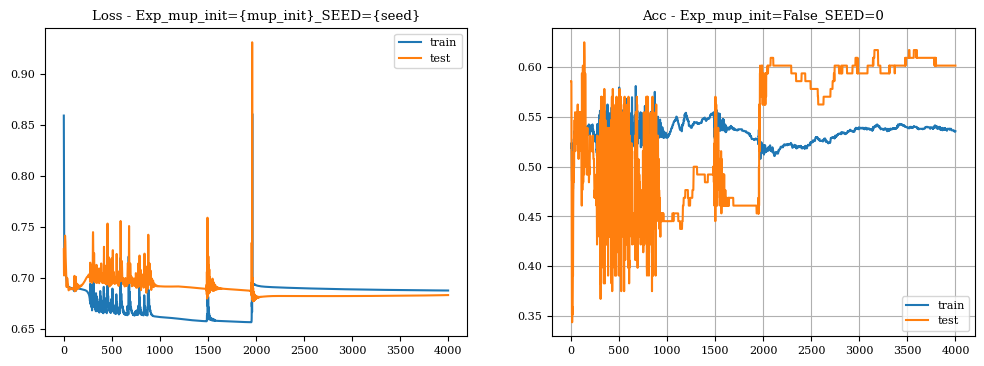

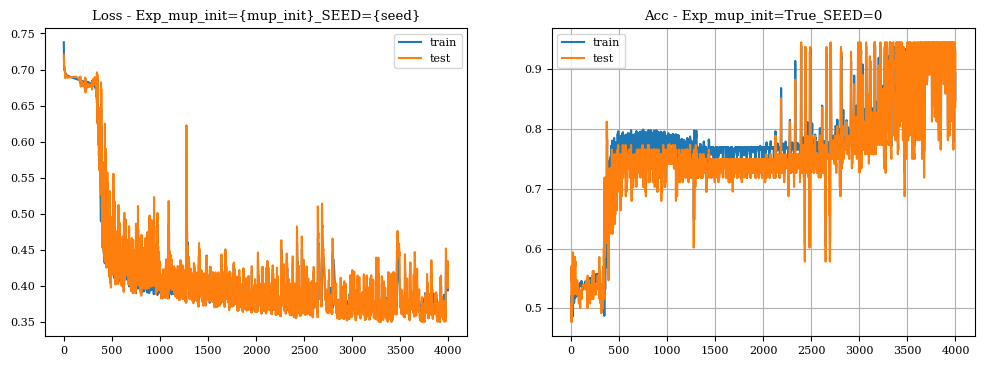

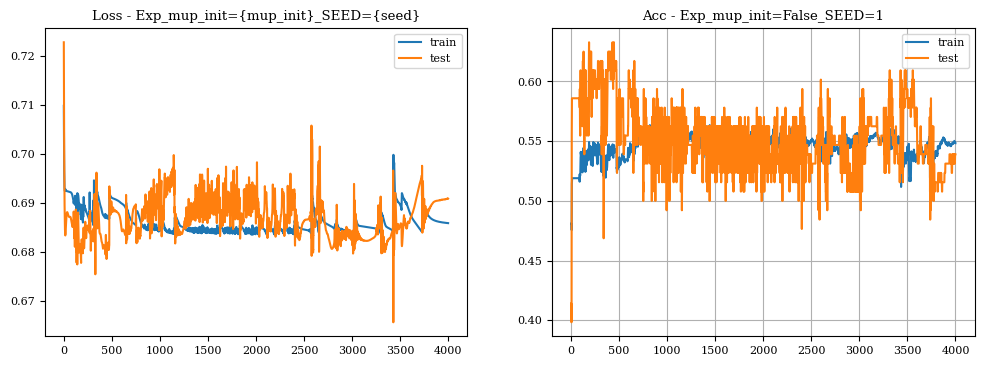

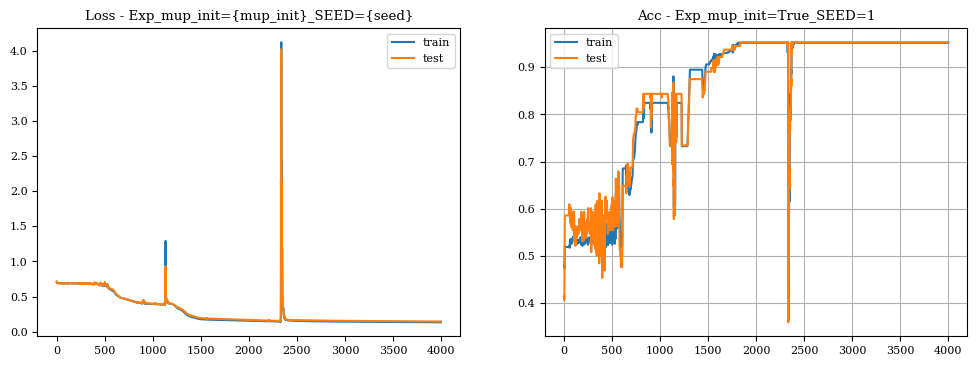

In [98]:
for seed in seed_list:
    for mup_init in [False, True]:
        path = f"exp_{seed}_mup_init_{mup_init}"
        path = os.path.join(SAVE_DIR, path)
        path = Path(path)

        weights = pickle.load(open(path / "weights.pkl", "rb"))
        losses = pickle.load(open(path / "losses.pkl", "rb"))
        test_losses = pickle.load(open(path / "test_losses.pkl", "rb"))
        accs = pickle.load(open(path / "accs.pkl", "rb"))
        test_accs = pickle.load(open(path / "test_accs.pkl", "rb"))

        fig, axes = plt.subplots(1, 2, figsize=(12, 4))
        axes[0].plot(losses, label="train")
        axes[0].plot(test_losses, label="test")
        axes[0].set_title("Loss - Exp_mup_init={mup_init}_SEED={seed}")
        axes[0].legend()
        axes[1].plot(accs, label="train")
        axes[1].plot(test_accs, label="test")
        axes[1].set_title("Accuracy")
        axes[1].legend()
        axes[1].grid()
        plt.title(f"Acc - Exp_mup_init={mup_init}_SEED={seed}")
        plt.show()